---
title: "QuantLib, dez anos depois ..."
description: |
    Voltei a mexer com a QuantLib, desta vez com Python, e não C++, que é a implementação
    original da biblioteca.
    Vamos ver aqui como a implementação em Python da QuantLib simplifica bastante as coisas.
author:
  - name: Wilson Freitas
    url: {}
date: 2023-07-19
categories:
  - python
  - quantlib
  - brasa
---

[QuantLib]: https://www.quantlib.org/

[QuantLib] é a essência do que é *quant*, não apenas pela óbvia menção no seu nome, e sim porque está
calcada na origem do que chamamos de *quantitative finance*.

A [QuantLib] é impressionante pelos seus superlativos, é uma biblioteca gigante, mantida por décadas e com
centenas de colaboradores.
Continua evoluindo como um projeto de código aberto e com uma comunidade engajada.

A QuantLib é uma grande biblioteca de *pricing* de ativos finaneiros, e com uma quantidade brutal de
instrumentos financeiros associada uma grande quantidade de insumos para os cálculos dos preços,
torna a implementação da biblioteca um esforço gigantesco.
Por exemplo, para calcular o preço de uma opção de dólar (das que são negociadas na B3) temos como insumos:
cotação do dólar, preço de *strike* da opção, prazo até o vencimento, taxas de juros locais, taxas de juros
*estrangeira*, volatilidade implícitas.
Para obter as taxas de juros, precisamos de uma estrutura a termo de juros que é formada por contratos futuros
negociados na B3.
As volatilidades implícitas são obtidas a partir de uma superfície de volatilidade que é construída de um conjunto de
opções, também negociadas na B3.
Os juros estrangeiros vão na mesma toada, ou seja, fazer isso de forma estruturada onde os insumos são
vinculados a toda cadeia de dependência de instrumentos financeiros e fatores de risco, é bastante complicado.
Sem mencionar todas as peculiaridades de cada mercado e seus produtos, como regimes de taxa e regras de contagem de
dias, apenas para citar alguns exemplos.

Infelizmente há muito pouco conteúdo sobre a QuantLib aplicado a instrumentos financeiros negociados no Brasil.
Vamos tentar reduzir este *gap* começando com a criação da curva de juros nominais do Brasil,
a estrutura a termo de taxas de juros prefixados.

## Obtendo os Dados

[brasa]: https://github.com/wilsonfreitas/brasa
[rb3]: https://github.com/ropensci/rb3

Vamos começar obtendo os dados da curva de juros nominais, a curva PRE, curva de juros prefixados obtida dos contratos
futuros de taxa DI negociados na B3.
Para isso vou utilizar a base de dados do projeto [brasa], projeto no qual venho trabalhando recentemente.
O projeto [brasa] organiza dados de diversas fontes do mercado financeiro brasileiro e disponibiliza *datasets*
com os dados previamente manipulados.
Este projeto é muito semelhante ao projeto [rb3], com a diferença que ele gera um *data lake* com dados do mercado
financeiro local.

In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"
import brasa
import pyarrow.compute as pc
from datetime import datetime

O projeto brasa organiza os dados em um conjunto de datasets que são obtidos através da função `brasa.get_dataset`.
Esta função retorna um objeto `Dataset` do projeto arrow, que pode ser entendido como uma referência para os dados,
uma vez que não traz os dados para a memória.

Vamos utilizar o *dataset* `b3-curves-di1` que contém as curvas de juros prefixados.

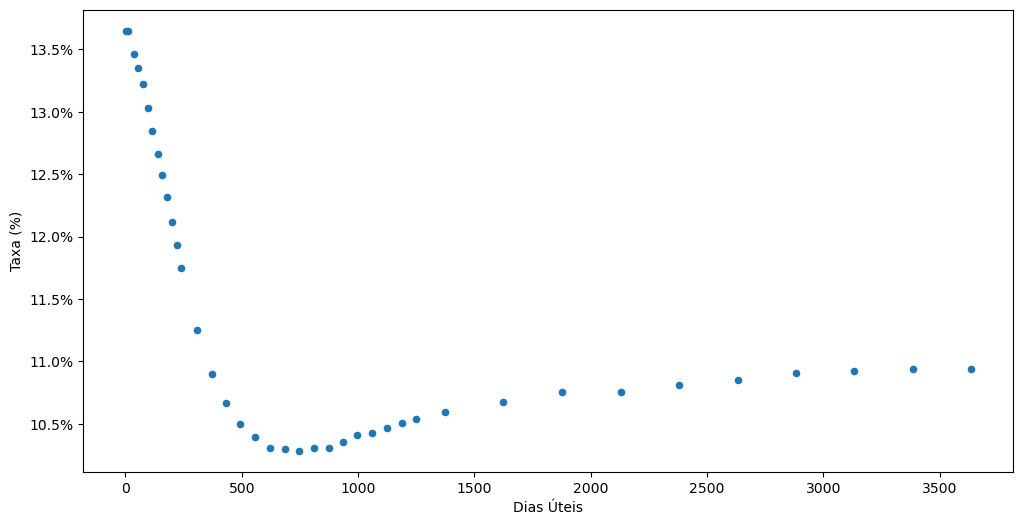

In [2]:
curve = (brasa
         .get_dataset("b3-curves-di1")
         .filter(pc.field("refdate") == datetime(2023, 7, 14))
         .to_table()
         .to_pandas())

import matplotlib.ticker as mticker

ax = curve.plot.scatter(x="business_days", y="adjusted_tax", figsize=(12, 6))
ax.set_xlabel("Dias Úteis")
ax.set_ylabel("Taxa (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1));

## Usando a QuantLib

Obtida a curva prefixada, com os seus vértices e taxas, agora vamos utilizar estes dados para criar objetos de curva da
QuantLib.

Começamos carregando a QuantLib e associando-a ao prefixo `ql`.
Tudo o que precisamos será acessado diretamente deste módulo.

In [3]:
import QuantLib as ql

today = ql.Date().from_date(datetime(2023, 7, 14))
ql.Settings.instance().evaluationDate = today
print(ql.Settings.instance().evaluationDate)

July 14th, 2023


A primeira coisa a fazer ao utilizar a QuantLib é definir a `evaluationDate`.
Esta é a data de avaliação, ou a data de marcação a mercado, ou a data de referência para a criação da curva, como
queira.
Como obtivemos a curva para o dia 14/julho/2023, vamos definir esta data como a `evaluationDate`.

A QuantLib tem o seu próprio objeto de data, `ql.Date`, e utilizei o método `ql.Date.from_date` para criar uma data
a partir de um objeto `datetime` do Python.

## DiscountCurve

A curva mais simples de ser criada na QuantLib é a `ql.DiscountCurve`.
Essa curva é criada a partir dos fatores de desconto, *discount factors*, que são independentes do regime de 
capitalização das taxas.
Em nosso caso, o regime de capitalização das taxas é o composto, com contagem de dias úteis, seguindo o calendário de
mercado do Brasil (calendário ANBIMA) e com ano de 252 dias.

O fator de desconto é um invariante, de forma que o fator de desconto entre duas datas é sempre o mesmo, independente
do regime de capitalização, da regra de contagem de dias e do calendário adotados.
Por este motivo que a `ql.DiscountCurve` é a curva mais simples de ser criada na QuantLib.

Para criar a `ql.DiscountCurve` é necessário obter o fator de desconto para cada uma das datas referentes aos vértices
da curva.
Para isso vamos criar um calendário de mercado do Brasil e obter as datas referentes aos vértices da curva, que estão
em dias úteis.
Adicionalmente, vamos calcular os fatores de desconto para cada um dos vértices.
Após a criação das datas e dos fatores de desconto, criamos o objeto com a regra de contagem de dias, que é necessário
para a curva, pois além das datas a curva também trabalha com prazos para retornar dados, e por isso precisa da
regra de contagem de dias para saber como converter prazos em datas e vice-versa.

In [4]:
calendar = ql.Brazil(ql.Brazil.Settlement)
data = [
    (calendar.advance(today, d, ql.Days, ql.Following), (1 + r) ** (-d/252))
    for d, r in zip(curve["business_days"], curve["adjusted_tax"])
]
data.insert(0, (today, 1))
dates, dfs = zip(*data)
dayCounter = ql.Business252(calendar)
curve0 = ql.DiscountCurve(dates, dfs, dayCounter)

Criamos o objeto `curve0` com a curva.
Note que inserimos um primeiro vértice na curva, referente a data de *hoje* (data de avaliação) com fator de desconto
igual a 1.
Isso é necessário, a `ql.DiscountCurve` exige isso.

Os vértices da curva podem ser obtidos com o método `nodes`, que retorna um conjuto de tuplas com data e fator de
desconto.

In [5]:
curve0.nodes()[:5]

((Date(14,7,2023), 1.0),
 (Date(17,7,2023), 0.9994923774382742),
 (Date(1,8,2023), 0.9939259),
 (Date(1,9,2023), 0.9826092000000001),
 (Date(2,10,2023), 0.9730136999999999))

A curva possui diversos métodos de interesse para se obter taxas e fatores de desconto.
O método `discount` retorna o fator de desconto e ele pode receber tanto a data futura, como o prazo, em anos, da
data de avaliação até a data futura.

Por exemplo, vamos obter o fator para a data de 1/set/2023 utilizando a data e o prazo até esta data.

In [6]:
biz_days = calendar.businessDaysBetween(today, ql.Date(1,9,2023))
print(curve0.discount(biz_days/252))
print(curve0.discount(ql.Date(1,9,2023)))

0.9826092000000001
0.9826092000000001


Como esta data também compõe a curva, ela é o quarto nó da curva, podemos verificar que os valores retornados
são iguais ao nó da curva.
Apenas um *sanity check*.

Contudo, podemos obter o fator de desconto para qualquer data e prazo, inclusive extrapolando o último vértice da curva.
Quando o prazo solicitado não for equivalente aos vértices da curva, a curva é interpolada, utilizando a interpolação
Log-Linear, linear nos logaritimos dos fatores de desconto.
Essa interpolação é equivalente a interpolação *flat-forward*, também conhecida como exponencial, utilizada
para curvas de juros compostos e dias úteis no Brasil.

Como exemplo vamos obter o fator para a data de 12/jul/2023.

In [7]:
fwd_date = ql.Date().from_date(datetime(2024, 7, 12))
biz_days = calendar.businessDaysBetween(today, fwd_date)
print(curve0.discount(biz_days/252))
print(curve0.discount(fwd_date))

0.8967097482832732
0.8967097482832732


O fator de desconto é muito útil no apreçamento de ativos, contudo, o que me interessa aqui é obter as taxas de juros
da curva.
As curvas são visualizadas em taxas e não em fatores.

Para obter as taxas de juros da curva, utilizamos o método `zeroRate`, que recebe o prazo em anos até a taxa e o
regime de capitalização.

In [8]:
print(curve0.zeroRate(biz_days/252, ql.Compounded))

11.665385 % Business/252(Brazil) Annual compounding


A taxa retornada é um objeto que contém frequência `Annual`, regime de capitalização `compounding` (juros compostos),
regra de contage de dias `Business/252` e calendário `Brazil`.
O valor da taxa é obtido com o método `rate` do objeto de taxa de juro retornado.

Vamos iterar em diversos prazos, começando em 1 dia até o último vértice da curva e obter as taxas de juros para cada
prazo e construir uma curva com estes dados, essa é a curva interpolada.
Depois, colocamos essa curva em um gráfico junto com a curva original.

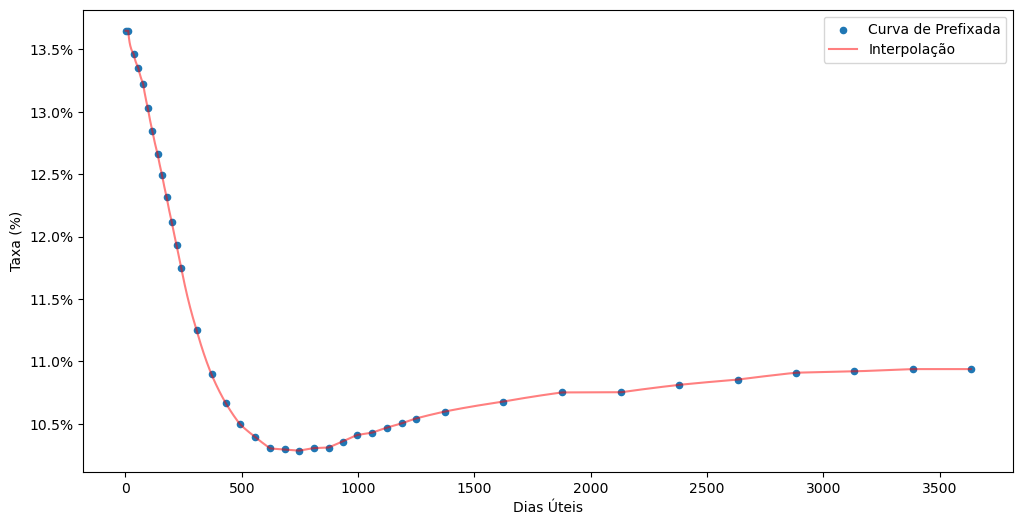

In [9]:
import pandas as pd

i_curve = pd.DataFrame({
    "days": list(range(1, curve["business_days"].max())),
    "rates": [curve0.zeroRate(i/252, ql.Compounded).rate()
              for i in range(1, curve["business_days"].max())],
})

ax = curve.plot.scatter(x="business_days", y="adjusted_tax", figsize=(12, 6),
                        label="Curva de Prefixada")
i_curve.plot(x="days", y="rates", c="red", alpha=0.5, ax=ax, label="Interpolação")
ax.set_xlabel("Dias Úteis")
ax.set_ylabel("Taxa (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1));

Uma outra análise que gosto de fazer é observar a curva de juros a termo de 1 dia.
É a expectativa das taxas DI futuras implícitas na curva.

O objeto de curva tem o método `forwardRate` que recebe um prazo inicial e um prazo final para o cálculo da taxa
a termo entre estes 2 prazos.
Dessa forma, vamos iterar em todos os prazos da curva obtendo a taxa a termo de 1 dia.
Na sequência vamos adicionar a estrutura a termo com estas taxas no gráfico com as curvas de juros.

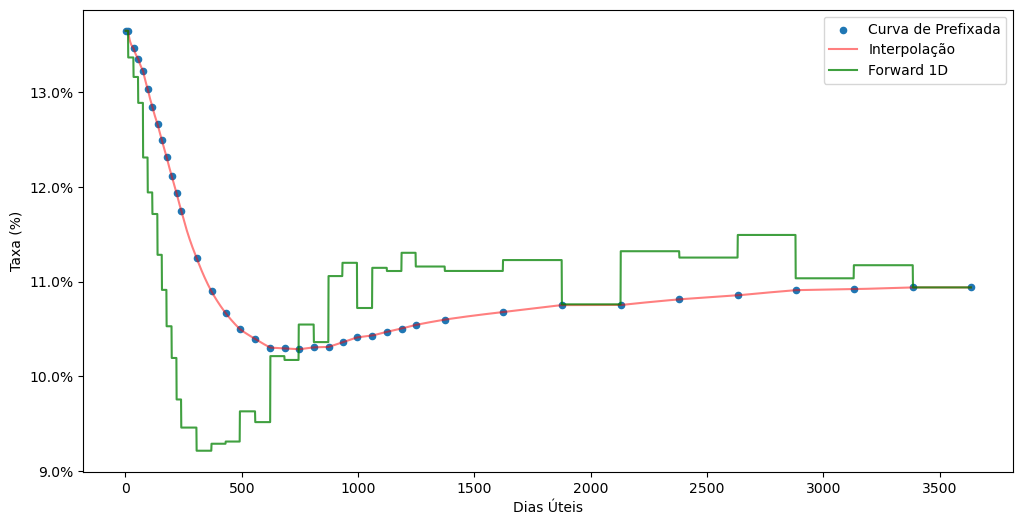

In [10]:
f_curve = pd.DataFrame({
    "days": list(range(1, curve["business_days"].max())),
    "rates": [curve0.forwardRate(i/252, (i+1)/252, ql.Compounded).rate()
              for i in list(range(1, curve["business_days"].max()))],
})

ax = curve.plot.scatter(x="business_days", y="adjusted_tax", figsize=(12, 6),
                        label="Curva de Prefixada")
i_curve.plot(x="days", y="rates", c="red", alpha=0.5, ax=ax, label="Interpolação")
f_curve.plot(x="days", y="rates", c="green", alpha=0.75, ax=ax, label="Forward 1D")
ax.set_xlabel("Dias Úteis")
ax.set_ylabel("Taxa (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1));


Dado o cenário atual, nota-se que a expectativa implícita na curva é de que a taxa DI reduza até a faixa de 9% em 1 ano
e retorne ao patamar de 10% após 2 anos.

Vamos ficando por aqui.
Vimos a criação de uma estrutura a termo com a QuantLib, como interpolar taxas de juros a vista e taxas de juros a
termo.